## Observations and Insights 

In [51]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path  = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results  = pd.read_csv(study_results_path)

##############################################################################
#  Findings: 1 - many relationship between mouse metadata and study results  #
#  Left join on mouse to include all test subjects to study results          #  
#                                                                            #
##############################################################################

mouse_df         = pd.DataFrame(mouse_metadata)
study_results_df = pd.DataFrame(study_results)

mouse_df.columns         # Index(['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)'], dtype='object')
study_results_df.columns # Index(['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'], dtype='object')

# Combine the data into a single dataset.  
merged_results_df = pd.merge(mouse_df, study_results_df, how="outer", on=["Mouse ID", "Mouse ID"])

# Display the data table for preview
merged_results_df.head(15)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
5,k403,Ramicane,Male,21,16,25,33.464577,1
6,k403,Ramicane,Male,21,16,30,31.099498,1
7,k403,Ramicane,Male,21,16,35,26.546993,1
8,k403,Ramicane,Male,21,16,40,24.365505,1
9,k403,Ramicane,Male,21,16,45,22.050126,1


In [52]:
# Checking the number of mice.
series_count = merged_results_df["Mouse ID"].unique()
print(f"Number of mice = {len(series_count)}")

Number of mice = 249


In [53]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint.

#Source: https://stackoverflow.com/questions/63888720/issue-while-using-loc-with-in-keyword
duplicate_ids  = merged_results_df[merged_results_df.duplicated(["Mouse ID", "Timepoint"])]["Mouse ID"].unique()
dupe_id_series =  merged_results_df.loc[(merged_results_df["Mouse ID"].isin(duplicate_ids))]
duplicated_mouse_id =  (pd.DataFrame(dupe_id_series)["Mouse ID"]).unique()[0]

print(f"Duplicated Mouse ID is '{duplicated_mouse_id}'")

Duplicated Mouse ID is 'g989'


In [54]:
# Optional: Get all the data for the duplicate mouse ID. 

duplicated_mouse_records_df = merged_results_df.loc[merged_results_df["Mouse ID"] == duplicated_mouse_id]
duplicated_mouse_records_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [55]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
dedupped_df = merged_results_df.loc[merged_results_df["Mouse ID"] != duplicated_mouse_id]

In [56]:
# Checking the number of mice in the clean DataFrame
mouse_count = len(dedupped_df["Mouse ID"].unique())
print(f"The new mouse count is {mouse_count}")

The new mouse count is 248


## Summary Statistics

In [59]:
#Part 1:
# Generate a summary statistics table of mean, median, variance, 
dedupped_df.describe()

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
#  (1) mean
#  (2) median
#  (3) variance 
#  (4) standard deviation
#  (5) SEM of the tumor volume

mean_series     = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].mean()
median_series   = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].median()
variance_series = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].var()
std_series      = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].std()
sem_series      = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].sem()

#Part 2:
# Assemble the resulting series into a single summary dataframe.

series_dictionary = {"Mean" : mean_series,
                     "Median" : median_series,
                     "Variance" : variance_series,
                     "Std Dev": std_series,
                     "SEM" : sem_series}

summary_df  = pd.DataFrame(series_dictionary)

#Appropriatley Format columns
summary_df["Mean"]     = summary_df["Mean"].map("{:.2f}".format)
summary_df["Median"]   = summary_df["Median"].map("{:.2f}".format)
summary_df["Variance"] = summary_df["Variance"].map("{:.2f}".format)
summary_df["StdDev"]   = summary_df["Std Dev"].map("{:.2f}".format) 
summary_df["SEM"]      = summary_df["SEM"].map("{:.2f}".format)

#Display Visualization
summary_df


,Mean,Median,Variance,Std Dev,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.45,43.85,6.62,0.54
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


In [72]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Using the aggregation method, produce the same summary statistics in a single line

#Source: https://stackoverflow.com/questions/19078325/naming-returned-columns-in-pandas-aggregate-function

#Reset the index for DataFrame re-use
dedupped_df.reset_index()

#1-line group-by/aggregation function
summary_df = dedupped_df.groupby(["Drug Regimen"]).agg(Mean=("Tumor Volume (mm3)",'mean'),
                                                       Median=("Tumor Volume (mm3)",'median'),
                                                       Variance=("Tumor Volume (mm3)",'var'),
                                                       StdDev=("Tumor Volume (mm3)",'std'),
                                                       SEM=("Tumor Volume (mm3)",'std'))
#Appropriatley Format columns
summary_df["Mean"]     = summary_df["Mean"].map("{:.2f}".format)
summary_df["Median"]   = summary_df["Median"].map("{:.2f}".format)
summary_df["Variance"] = summary_df["Variance"].map("{:.2f}".format)
summary_df["StdDev"]   = summary_df["StdDev"].map("{:.2f}".format) 
summary_df["SEM"]      = summary_df["SEM"].map("{:.2f}".format)

#Display Visualization
summary_df

,Mean,Median,Variance,StdDev,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,4.99
Ceftamin,52.59,51.78,39.29,6.27,6.27
Infubinol,52.88,51.82,43.13,6.57,6.57
Ketapril,55.24,53.70,68.55,8.28,8.28
Naftisol,54.33,52.51,66.17,8.13,8.13
Placebo,54.03,52.29,61.17,7.82,7.82
Propriva,52.32,50.45,43.85,6.62,6.62
Ramicane,40.22,40.67,23.49,4.85,4.85
Stelasyn,54.23,52.43,59.45,7.71,7.71


## Bar and Pie Charts

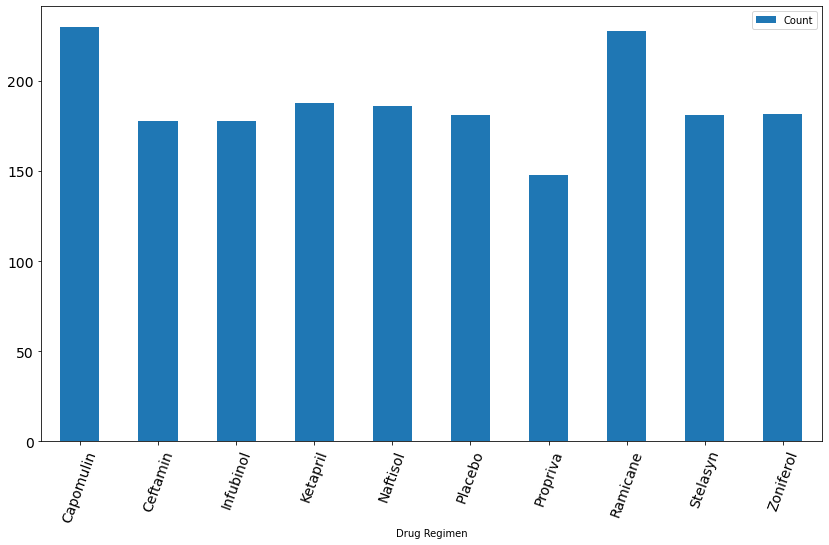

In [132]:
#Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
#Basically, the count of records for for each drug regimen

df = dedupped_df.groupby(["Drug Regimen"])["Mouse ID"].count()                                 \
                                                      .reset_index()                           \
                                                      .rename(columns={"Mouse ID": "Count"})   \
                                                      .plot.bar(x="Drug Regimen",              \
                                                                y="Count",                     \
                                                                rot=70,                        \
                                                                figsize=(14,8),                \
                                                                fontsize=14)

In [89]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.



In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas



In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot



## Quartiles, Outliers and Boxplots

In [ ]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [ ]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
